**SARCASM DETECTION**
>Trương Đức Vũ 18520194\
Trần Trung Anh 18520473

**MÔ TẢ BÀI TOÁN VÀ CÁCH THU THẬP DỮ LIỆU**
>Sarcasm Detection (Nhận diện lời nói châm chọc) là một lĩnh vực hẹp của Xử lý ngôn ngữ tự nhiên, đây cũng là một dạng của Phân tích cảm xúc nhưng tập trung vào những lời châm chọc. Nhiệm vụ của bài toán này là phát hiện một câu văn có mang tính châm chọc hay không.
>>*Input*: một câu văn.\
>>*Ouput*: Câu văn đó mang tính châm chọc, hoặc không mang tính châm chọc.

>Cách thu thập dữ liệu:\
Các tác giả của bộ dữ liệu đã thu thập tiêu đề của những bài báo trên 2 trang Huffpost và TheOnion. Trong đó, hầu hết những bài báo của TheOnion đều mang tính châm chọc, trong khi đó những bài của Huffpost thì không nên tác giả có thể "tự động" gán nhãn với độ chính xác cao. Bên cạnh đó, 2 trang trên đều là những trang báo uy tính nên có thể hạn chế việc sai chính tả và những tiêu đề không phù hợp.

**TẢI DỮ LIỆU TỪ KAGGLE VÀ NHẬP DỮ LIỆU**

---





In [ ]:
# DOWNLOAD DATASET FROM KAGGLE
from google.colab import files
files.upload()
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets list -s sarcasm

ref                                                      title                                               size  lastUpdated          downloadCount  
-------------------------------------------------------  -------------------------------------------------  -----  -------------------  -------------  
danofer/sarcasm                                          Sarcasm on Reddit                                  216MB  2018-05-27 08:19:04           4586  
rmisra/news-headlines-dataset-for-sarcasm-detection      News Headlines Dataset For Sarcasm Detection         3MB  2019-07-03 23:52:57          15616  
rmisra/news-category-dataset                             News Category Dataset                               25MB  2018-12-02 04:09:45          13216  
sherinclaudia/sarcastic-comments-on-reddit               Sarcastic Comments - REDDIT                        106MB  2019-01-30 14:41:53           1931  
rmisra/clothing-fit-dataset-for-size-recommendation      Clothing Fit Dataset for Size R

In [ ]:
!kaggle datasets download -d rmisra/news-headlines-dataset-for-sarcasm-detection

news-headlines-dataset-for-sarcasm-detection.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!mkdir ~/.kaggle/datasets
!mv news-headlines-dataset-for-sarcasm-detection.zip ~/.kaggle/datasets
%cd ~/.kaggle/datasets
!ls
!unzip news-headlines-dataset-for-sarcasm-detection.zip

mkdir: cannot create directory ‘/root/.kaggle/datasets’: File exists
mv: 'news-headlines-dataset-for-sarcasm-detection.zip' and '/root/.kaggle/datasets/news-headlines-dataset-for-sarcasm-detection.zip' are the same file
/root/.kaggle/datasets
kaggle.json
new_headlines.json
news-headlines-dataset-for-sarcasm-detection.zip
Sarcasm_Headlines_Dataset.json
Sarcasm_Headlines_Dataset_v2.json
Archive:  news-headlines-dataset-for-sarcasm-detection.zip
replace Sarcasm_Headlines_Dataset.json? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace Sarcasm_Headlines_Dataset_v2.json? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


In [ ]:
# IMPORT LIBRARIES 
import pandas as pd
import numpy as np
from nltk import download
from nltk.corpus import stopwords
from string import punctuation

In [ ]:
# IMPORT DATASET
dataset = pd.read_json('Sarcasm_Headlines_Dataset.json', lines=True)
dataset.head(5)

article_link  ... is_sarcastic
0  https://www.huffingtonpost.com/entry/versace-b...  ...            0
1  https://www.huffingtonpost.com/entry/roseanne-...  ...            0
2  https://local.theonion.com/mom-starting-to-fea...  ...            1
3  https://politics.theonion.com/boehner-just-wan...  ...            1
4  https://www.huffingtonpost.com/entry/jk-rowlin...  ...            0

[5 rows x 3 columns]

In [ ]:
X = dataset['headline']
y = dataset['is_sarcastic']

In [ ]:
# Count number of each class
sarcastic_n = 0
not_sarcastic_n = 0
for value in y:
  if value == 0:
    not_sarcastic_n += 1
  else:
    sarcastic_n += 1

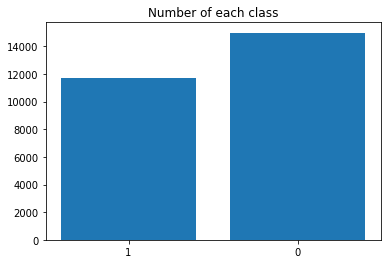

In [ ]:
import matplotlib.pyplot as plt
names = ['1', '0']
plt.bar(names, [sarcastic_n, not_sarcastic_n])
plt.title('Number of each class')
plt.show()

**TIỀN XỬ LÝ DỮ LIỆU**

*Xoá stopwords và dấu câu:*
>Stopwords là các từ không mang ý nghĩa, hoặc chứa rất ít nghĩa cho câu văn. Một số stopwords trong Tiếng Anh như: the, and, is, at, which,...
Có thể tìm đầy đủ hơn trong thư viện nltk.corpus.stopwords đã khai báo.\
>Tương tự với dấu câu, cũng không mang nhiều thông tin nên ta loại bỏ. Các dấu câu được liệt kê trong string.punctuation.

*Chuyển tất cả ký tự thành dạng viết thường:*
>Ví dụ hai từ: Dog và dog đều có cùng một ý nghĩa nhưng khi xử lý trong máy tính, chúng được hiểu như 2 từ khác nhau nên ta cần đưa chúng về cùng 1 dạng.\
Tuy nhiên, cũng có một số ngoại lệ như danh từ riêng, nếu đưa về dạng viết thường sẽ có ý nghĩa khác.


In [ ]:
download('stopwords') # nltk.download stopwords
stopws = set(stopwords.words('english'))
puncs = set(punctuation) # string.punctuation

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
def preprocess(data):
  data_len = len(data)
  for i in range(data_len):
    tmp = ''
    for eachWord in data[i].split():
      for p in puncs: # remove punctuations
        if p in eachWord:
          eachWord = eachWord.replace(p, '')
      for s in stopws: # remove stopwords
        if s == eachWord:
          eachWord = ''
      tmp = tmp + eachWord + ' '
    data[i] = tmp[:-1].lower() # remove the last blankspace
  return data

In [ ]:
X = preprocess(X)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


In [ ]:
X.head(10)

0    former versace store clerk sues  secret black ...
1     roseanne revival catches    thorny political ...
2    mom starting  fear sons web series closest thi...
3    boehner  wants wife  listen  come   alternativ...
4    jk rowling wishes snape happy birthday    magi...
5                              advancing  worlds women
6               fascinating case  eating labgrown meat
7             ceo  send  kids  school   work   company
8    top snake handler leaves sinking huckabee camp...
9    fridays morning email inside trumps presser   ...
Name: headline, dtype: object

**TRÍCH XUẤT ĐẶC TRƯNG**\
Sử dụng phương pháp *Term Frequency - Inverse Document Frequency* (TF-IDF).\
Giá trị TF-IDF của một từ là một số thu được bằng cách thống kê mức độ quan trọng của từ này trong một câu, mà câu đang xét nằm trong một tập hợp các câu, ở đâu chính là toàn bộ dữ liệu. Trong đó:
>Term Frequency: tần số xuất hiện của một từ trong một câu.\
>Inverse Document Frequency: nghịch đảo tần số của một từ trong toàn bộ các câu.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vec = TfidfVectorizer(max_features=5000)

In [ ]:
X_train_tfidf = tfidf_vec.fit_transform(X)

**LỰA CHỌN MODEL VÀ HUẤN LUYỆN**\
Sử dụng hai thuật toán *Support Vector Machine* (SVM) và *Multinominal Naive Bayes* (MNB)./
Bài toán đưa ra là dạng bài phân loại, trong đó kết quả đầu ra là một trong hai giá trị 0 (không châm chọc) hoặc 1 (châm chọc). SVM và MNB là hai thuật toán phù hợp cho bài toán này.\
Ở đây, SVM và MNB đều được huấn luyện với toàn bộ dữ liệu, giai đoạn kiểm thử sẽ được thực thi với tập dữ liệu mới, sẽ được đề cập sau.


In [ ]:
# Import SVM
from sklearn.svm import LinearSVC
SVM = LinearSVC()

In [ ]:
# Import MNB
from sklearn.naive_bayes import MultinomialNB
MNB = MultinomialNB()

In [ ]:
# Train models with training data
SVM.fit(X_train_tfidf, y)
MNB.fit(X_train_tfidf, y)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

**THU THẬP 2000 HEADLINES MỚI**


- Sử dụng thư viện selenium để tự động duyệt web.
- Truy cập trang chủ của Huffpost và TheOnion.
- Trong mỗi file html của trang báo, tìm kiếm tag của headline.
- Từ đó thu thập, với headline từ Huffpost gán nhãn is_sarcastic với giá trị 0, ngược lại từ TheOnion gán nhãn 1.
- Cuối cùng ghi vào file.



**NOTE**: Chi tiết source code truy cập link sau https://drive.google.com/file/d/1ATc8BszJjr937iUh-RgGBHVyYSARVMho/view?fbclid=IwAR05pb_HhjGGIGZynEtEVJBmtj1MovjAXaM0gcsCsYo-GuGesz8zjU-lYic

**THỬ NGHIỆM VỚI BỘ DỮ LIỆU MỚI**

In [ ]:
# new_headlines uploaded from local machine
!mv /content/new_headlines.json ~/.kaggle/datasets

In [ ]:
# new headline for testing
new_dataset = pd.read_json('new_headlines.json', lines=True)
new_dataset.head(5)

headline  is_sarcastic
0  Just A Reminder: This Is How Alcohol Affects Y...             0
1  1.5 Million More Americans Sought Unemployment...             0
2  Trump Holds Diplomatic Ceremony To Formally We...             1
3  Georgia Bill Would Stop Officials From Mailing...             0
4  All I Want For My 90th Birthday Is To Abolish ...             0

In [ ]:
X_new = new_dataset['headline']
y_new = new_dataset['is_sarcastic']

In [ ]:
X_new.head(5)

0    Just A Reminder: This Is How Alcohol Affects Y...
1    1.5 Million More Americans Sought Unemployment...
2    Trump Holds Diplomatic Ceremony To Formally We...
3    Georgia Bill Would Stop Officials From Mailing...
4    All I Want For My 90th Birthday Is To Abolish ...
Name: headline, dtype: object

In [ ]:
# Preprocess for new headlines, same as training data
X_new = preprocess(X_new)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


In [ ]:
X_new.head(5)

0    just a reminder this is how alcohol affects yo...
1    15 million more americans sought unemployment ...
2    trump holds diplomatic ceremony to formally we...
3    georgia bill would stop officials from mailing...
4    all i want for my 90th birthday is to abolish ...
Name: headline, dtype: object

In [ ]:
X_test_tfidf = tfidf_vec.transform(X_new)
SVM_predict = SVM.predict(X_test_tfidf)
MNB_predict = MNB.predict(X_test_tfidf)

In [ ]:
# Calculate Accuracy, Precision, Recall scores
from sklearn.metrics import precision_score, recall_score, accuracy_score
SVM_results = [round(precision_score(SVM_predict, y_new) * 100, 2), \
               round(recall_score(SVM_predict, y_new) * 100, 2), \
               round(accuracy_score(SVM_predict, y_new) * 100, 2)]
MNB_results = [round(precision_score(MNB_predict, y_new) * 100, 2), \
               round(recall_score(MNB_predict, y_new) * 100, 2), \
               round(accuracy_score(MNB_predict, y_new) * 100, 2)]
dtf = pd.DataFrame(list(zip(SVM_results, MNB_results)), columns=['SVM', 'MNB'], index=['Precision', 'Recall', 'Accuracy'])
dtf

SVM    MNB
Precision  64.80  61.10
Recall     77.14  81.36
Accuracy   72.80  73.55

**SỬ DỤNG MODEL ĐÃ HUẤN LUYỆN ĐỂ XÂY DỰNG ỨNG DỤNG**\
Với hai model đã có, ta đơn giản chỉ cần yêu cầu dữ liệu nhập vào, thực hiện bước tiền xử lý cho dữ liệu đó giống với dữ liệu huấn luyện.\
Sau đó, thực hiện trích xuất đặc trưng dựa trên vector đặc trưng đã huấn luyện.\
Cuối cùng, thực hiện bước dự đoán để tìm ra kết quả.

In [ ]:
user_input = input('Enter a new headline:')
user_input = np.array(user_input)
user_input = preprocess(user_input)
input_tfidf = tfidf_vec.transform(user_input)
input_predict = MNB.predict(input_tfidf) 
print(input_predict)


Nhập một headline bất kỳ

In [ ]:
headline = input()

Tiền xử lý dữ liệu
> Headline xóa các dấu chấm câu, chuyển về chử in thường.. 

In [ ]:
headline = preprocess(headline)

Mã hóa headline về vector

In [ ]:
headline = tf.fit_transform(headline).toarray()

Dự đoán

In [ ]:

predict = model2.predict(headline)

In [ ]:
if predict == 1:
    print("This is sarcastic")
else:
    print("This isn't sarcastic")

***ĐỐI CHIẾU NHẬN XÉT PERFORMANCE. NHẬN XÉT***

Hiệu suất khi test với bộ test mới được thu thập là thấp hơn 
trước đó. Bởi vì dữ liệu mới có nhiều thông tin mới và có 
những từ ngữ không có trong bộ từ điển mà model trước đó đã xây dựng, dẫn đến sai lệch và dẫn tới accuracy giảm.

Đây là một bài toán khá khó khi chỉ sử dụng các thuật toán thông thường của machine learning, vì các từ ngư được phân theo BoW, nên khi thêm các bài báo mới, bộ từ điển có thể bị thiếu hụt.
